In [18]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

In [19]:
TARGET_COL = "duration_minutes"
OTHERS = ["duration", "genre_top"]
TEST_SIZE = 0.2
N_SPLITS = 4

## Load merged dataset

In [20]:
df_train = pd.read_csv("../DataBase/processed/train_data.csv")
print(df_train.shape)

df_test = pd.read_csv("../DataBase/processed/test_data.csv")
print(df_test.shape)

(5493, 41)
(1374, 41)


## Data preprocessing

In [21]:
df_train = df_train[df_train[TARGET_COL].notna()].dropna().copy()
print(df_train.shape)

df_test = df_test[df_test[TARGET_COL].notna()].dropna().copy()
print(df_test.shape)

(5493, 41)
(1374, 41)


In [22]:
df_train[TARGET_COL].min()

np.float64(0.3)

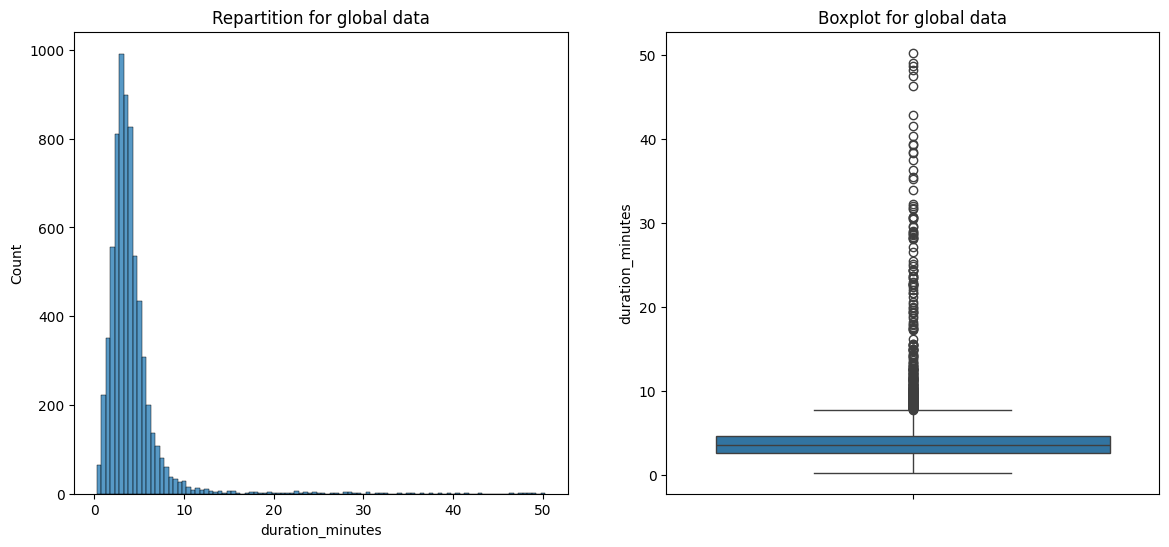

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(pd.concat([df_train[TARGET_COL], df_test[TARGET_COL]]), bins=100, ax=axes[0])
axes[0].set_title("Repartition for global data")
sns.boxplot(pd.concat([df_train[TARGET_COL], df_test[TARGET_COL]]), ax=axes[1])
axes[1].set_title("Boxplot for global data")
plt.show()

In [24]:
LIMIT_TIME_MIN, LIMIT_TIME_MAX = 1, 8
df_train = df_train[(df_train["duration_minutes"] <= LIMIT_TIME_MAX) & (df_train["duration_minutes"] >= LIMIT_TIME_MIN)]
df_test = df_test[(df_test["duration_minutes"] <= LIMIT_TIME_MAX) & (df_test["duration_minutes"] >= LIMIT_TIME_MIN)]

In [25]:
X_train, X_test = df_train.drop(columns=[TARGET_COL] + OTHERS), df_test.drop(columns=[TARGET_COL] + OTHERS)
y_train, y_test = df_train[TARGET_COL], df_test[TARGET_COL]

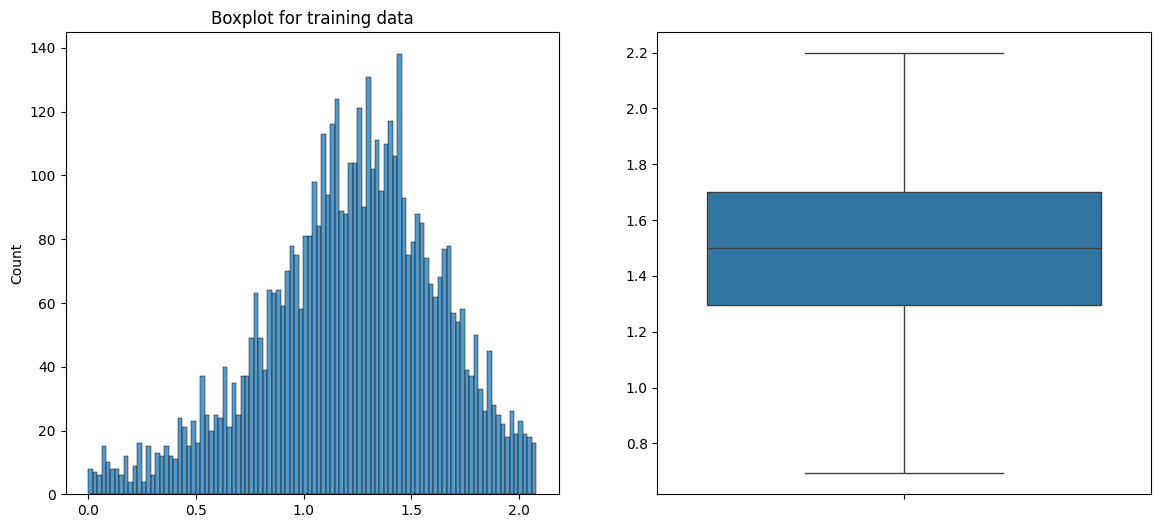

In [26]:
y_train_transformed = [np.log1p(value) for value in y_train]
y_test_transformed = [np.log1p(value) for value in y_test]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot([np.log(value) for value in y_train], bins=100, ax=axes[0])
axes[0].set_title("Repartition for training data")
sns.boxplot([np.log(value + 1) for value in y_train], ax=axes[1])
axes[0].set_title("Boxplot for training data")
plt.show()

## Model training

## With coarse_genre_top GroupKFold

In [27]:
kfolf = KFold(N_SPLITS)

In [28]:
def inv_transform(value):
    return np.exp(value) - 1

### SVM

In [29]:
svm = SVR()

scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
scores = cross_validate(
	svm,
	X_train,
	y_train_transformed,
	cv=kfolf,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.2996 +- 0.0026
MSE: 0.0898 +- 0.0016
r2: 0.0338 +- 0.0142


In [30]:
svm.fit(X_train, y_train_transformed)
predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.3128
MSE:, 0.0979
r2: 0.0393
----------------------
Metrics in original space:
RMSE: 1.4430
MSE:, 2.0823
r2: 0.0345


### Random Forest

In [31]:
random_forest = RandomForestRegressor()

scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
scores = cross_validate(
	random_forest,
	X_train,
	y_train_transformed,
	cv=kfolf,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.1576 +- 0.0033
MSE: 0.0249 +- 0.0010
r2: 0.7325 +- 0.0082


In [32]:
random_forest.fit(X_train, y_train_transformed)
predictions = random_forest.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.1551
MSE:, 0.0241
r2: 0.7637
----------------------
Metrics in original space:
RMSE: 0.7172
MSE:, 0.5144
r2: 0.7615


### XGBoost

In [33]:
xgb = XGBRegressor()

scores = cross_validate(
	xgb,
	X_train,
	y_train_transformed,
	cv=kfolf,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.1687 +- 0.0046
MSE: 0.0285 +- 0.0015
r2: 0.6935 +- 0.0135


In [34]:
xgb.fit(X_train, y_train_transformed)
predictions = xgb.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.1624
MSE:, 0.0264
r2: 0.7411
----------------------
Metrics in original space:
RMSE: 0.7448
MSE:, 0.5548
r2: 0.7428
